###  v4-Movie-Genre-Classifier - using BERT NLP Embedding


In [1]:
import pandas as pd
import numpy as np
import sys, os

from sklearn.preprocessing import MultiLabelBinarizer
import json
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

import tensorflow_hub as hub
import bert
from bert.tokenization.bert_tokenization import FullTokenizer

import hashlib
import math
from collections import namedtuple
from tqdm import tqdm



In [2]:
movie_metadata_file = './data/movie.metadata.tsv'
movie_plot_file = './data/plot_summaries.txt'

model_file = './data/movie_model.h5'
bert_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"

In [3]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

VOCAB_WORDLIMIT = 100000
SEQUENCE_LEN = 200
assert SEQUENCE_LEN < 512, "The maximun permissible sequence length for BERT is 512"

BATCH_SIZE = 32
assert BATCH_SIZE < 33, "The tensor flow model.fit hangs up on last epoch for batch size > 32"

EPOCHS = 4
LEARNING_RATE = 1e-3

MAX_COUNT = 8

top_genre = ['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'World cinema', 'Crime Fiction', 'Horror']



In [4]:
print("tensorflow version ->", tf.__version__)
print("sys/python version ->", sys.version)
np.set_printoptions(precision=2)


tensorflow version -> 2.1.0
sys/python version -> 3.7.6 (default, Dec 30 2019, 19:38:28) 
[Clang 11.0.0 (clang-1100.0.33.16)]


# Model

### BERT

* sequence_output is suitable in "Q&A" problem
* whereas, pooled output in suitable for classification problem
* local caching info

    hashlib.sha1(bert_url.encode("utf8")).hexdigest()
    '03d6fb3ce1605ad9e5e9ed5346b2fb9623ef4d3d'


In [5]:
bert_layer = hub.KerasLayer(bert_url, trainable=False, name="BERT")

In [6]:
def build_model():    
    label_count = len(top_genre)    
    input_word_ids = Input(shape=(SEQUENCE_LEN,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(SEQUENCE_LEN,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(SEQUENCE_LEN,), dtype=tf.int32, name="segment_ids")
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    pred_label = Dense(label_count, activation="sigmoid", name='pred_label')(pooled_output)
    pred_count = Dense(MAX_COUNT, activation="softmax", name='pred_count')(pooled_output)
    
    
    
    model = Model([input_word_ids, input_mask, segment_ids], outputs=[pred_label, pred_count])
    return model


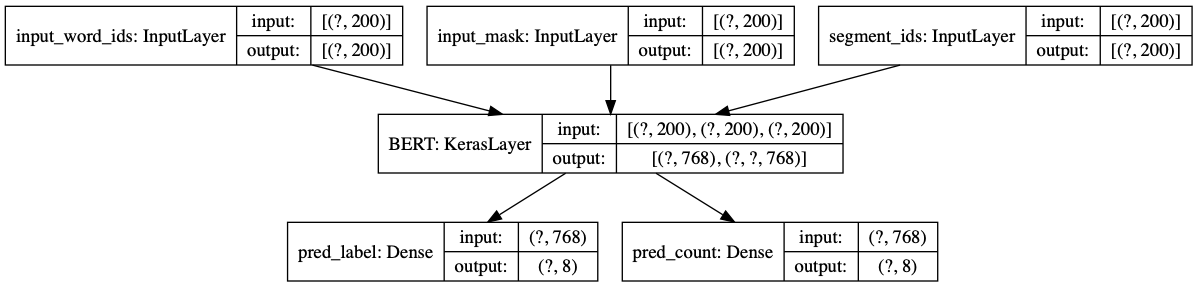

In [7]:
model = build_model()
plot_model(model, 'model.png', show_shapes=True)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

##### BERT Preprocessing
ref: https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

The BERT layer requires 3 input sequence:

* Token ids: for every token in the sentence. We restore it from the BERT vocab dictionary
* Mask ids: for every token to mask out tokens used only for the sequence padding (so every sequence has the same length).
* Segment ids: 0 for one-sentence sequence, 1 if there are two sentences in the sequence and it is the second one
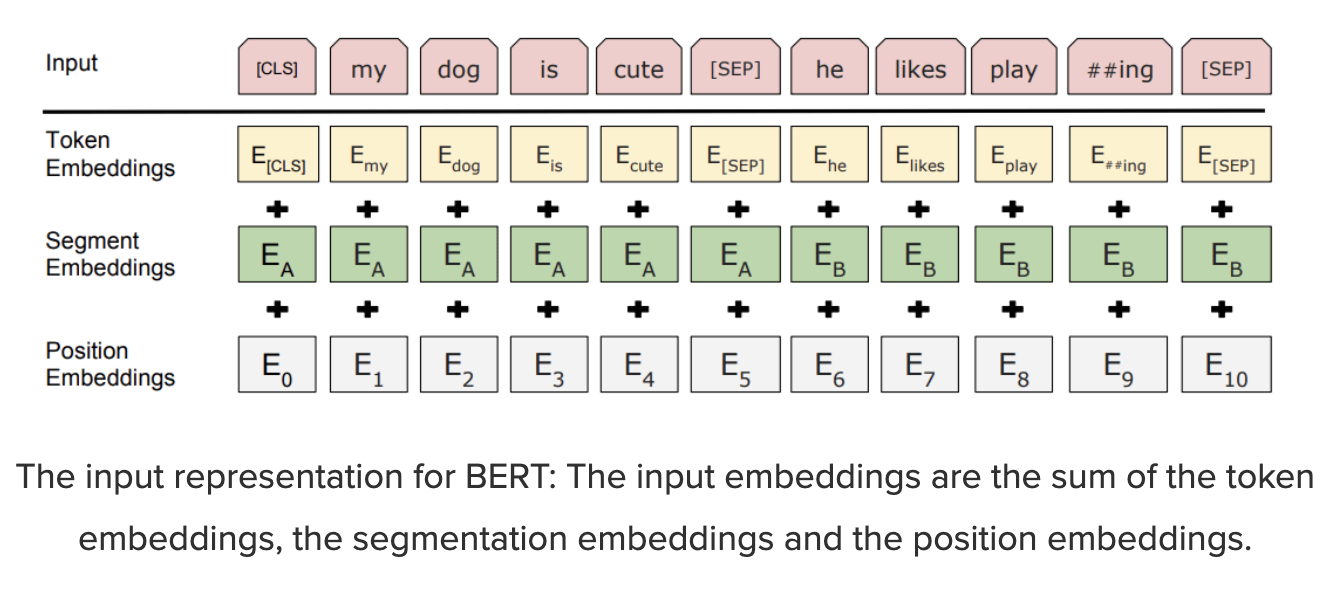

### Data Preparation

In [9]:
def clean_text(text):
 text = BeautifulSoup(text, "lxml").text
 text = text.lower() # lowercase text
 text = REPLACE_BY_SPACE_RE.sub(' ', text)
 text = BAD_SYMBOLS_RE.sub('', text)
 text = ' '.join(word for word in text.split() if word not in STOPWORDS)
 return text

In [10]:
def download_metadata(movie_metadata_file):
    df_metadata = pd.read_csv(movie_metadata_file, engine='python', sep = '\t', header = None,
                     quotechar='"', error_bad_lines=False, warn_bad_lines=False)
    df_metadata.head(2)    
    return df_metadata

In [11]:
df_metadata = download_metadata(movie_metadata_file)

In [12]:
def download_plot(movie_plot_file):
    df_plot = pd.read_csv(movie_plot_file, engine='python', sep = '\t', header = None,
                     quotechar='"', error_bad_lines=False, warn_bad_lines=False)
    df_plot.head(2)
    return df_plot

In [13]:
df_plot = download_plot(movie_plot_file)

In [14]:
def merge_plot_and_metadata():
    df_metadata.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
    df_plot.columns = ["movie_id", "plot"]
   
    df_dataset =  pd.merge(df_metadata[["movie_id","movie_name","genre"]],
                           df_plot[["movie_id", "plot"]], on="movie_id")
    return df_dataset


In [15]:
df_dataset = merge_plot_and_metadata()

In [16]:
def select_top_genre():
    genre_list = []
    for i in df_dataset['genre']:
        gen_filtered = []
        gen = json.loads(i).values()
        [gen_filtered.append(j) for j in list(gen) if j in top_genre]
        genre_list.append(gen_filtered)
    df_dataset['genre'] = genre_list
    df_dataset.head(2)
    return df_dataset

In [17]:
df_dataset = select_top_genre()

In [18]:
def clean_plot_text():
    df_dataset['plot'] = df_dataset['plot'].apply(clean_text)
    return df_dataset

df_dataset = clean_plot_text()

In [19]:
def append_columns(df, arr, col_names=[]):
    assert arr.shape[0]==len(df), "mismatch in number of rows"
    if col_names==[]:
        col_names = range(arr.shape[1])
    else:
        col_names = list(col_names)
    df_add = pd.DataFrame(arr, columns=col_names)
    
    df = pd.merge(df, df_add, how='left', left_index=True, right_index=True)

    print("added df_add ->:", df_add.shape, "to df; new shape->:", df.shape, len(df))
    assert (df_add.shape[0]==len(df)), "mismatch in number of rows"
    assert (df_add.shape[1]==len(col_names)), "mismatch in number of columns"
    return df


In [20]:
def get_tokenizer():
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    print("vocab file located at:\n", vocab_file)
    tokenizer = FullTokenizer(vocab_file)
    
    print("testing access to vocab.txt")
    print("'corona' ->" , tokenizer.convert_tokens_to_ids(['corona']))
    print("'21887' ->" , tokenizer.convert_ids_to_tokens([21887]))
    return tokenizer

tokenizer = get_tokenizer()

vocab file located at:
 b'/Users/bp/tf-hub-cache/03d6fb3ce1605ad9e5e9ed5346b2fb9623ef4d3d/assets/vocab.txt'
testing access to vocab.txt
'corona' -> [21887]
'21887' -> ['corona']


In [21]:
def get_masks(tokens):
    masks = [1]*len(tokens) + [0]*(SEQUENCE_LEN - len(tokens))
    return masks

In [22]:
def get_segments(tokens):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    segments = segments + [0]*(SEQUENCE_LEN - len(tokens)) 
    return segments

In [23]:
def get_ids(tokens):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    token_ids = token_ids + [0]*(SEQUENCE_LEN - len(token_ids))
    return token_ids

In [24]:
def create_single_input(sample):
    sample_tokens = tokenizer.tokenize(sample)
    sample_tokens = sample_tokens[:(SEQUENCE_LEN-2)]
    sample_tokens = ["[CLS]"] + sample_tokens + ["[SEP]"]
    
    ids = get_ids(sample_tokens)
    masks = get_masks(sample_tokens)
    segments = get_segments(sample_tokens)

    return ids, masks, segments

In [25]:
def create_triple_input(df):
    input_ids, input_masks, input_segments = [], [], []
    
    for sample in tqdm(df, position=0, leave=True):
        ids, masks, segments = create_single_input(sample)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
    
    triple_input = [np.asarray(input_ids, dtype=np.int32),
                    np.asarray(input_masks, dtype=np.int32), 
                    np.asarray(input_segments, dtype=np.int32)]

    return triple_input

In [26]:
def hot_multicode_utility(df):
    mlb = MultiLabelBinarizer()
    mlb.fit_transform(df)
    genres = mlb.classes_
    hot_multicode = mlb.transform(df)
    print('hot_multicode ->', type(hot_multicode), hot_multicode.shape, '\n',
         genres)
    assert (hot_multicode.shape[1]==len(top_genre)), "num of genre labels do not match with hot encoded list"
    assert (hot_multicode.shape[0]==len(df)), "inconsistent number of samples processed"
    return hot_multicode, genres


## Generate dataset derived X, Y data

In [27]:
hot_multicode, genres = hot_multicode_utility(df_dataset['genre'])

hot_multicode -> <class 'numpy.ndarray'> (42071, 8) 
 ['Action' 'Comedy' 'Crime Fiction' 'Drama' 'Horror' 'Romance Film'
 'Thriller' 'World cinema']


In [28]:
triple_input = create_triple_input(df_dataset['plot'])

100%|██████████| 42071/42071 [02:46<00:00, 252.47it/s]


## Add new columns for derived data

In [29]:
df_dataset = append_columns(df_dataset, hot_multicode, col_names=genres)


added df_add ->: (42071, 8) to df; new shape->: (42071, 12) 42071


/Users/bp/Environments/deep/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
df_dataset = append_columns(df_dataset, triple_input[0])

added df_add ->: (42071, 200) to df; new shape->: (42071, 212) 42071


In [31]:
df_dataset = append_columns(df_dataset, triple_input[1])

added df_add ->: (42071, 200) to df; new shape->: (42071, 412) 42071


In [32]:
df_dataset = append_columns(df_dataset, triple_input[2])

added df_add ->: (42071, 200) to df; new shape->: (42071, 612) 42071


In [33]:
def filter_unlabeled_data(df, start_col = 4, end_col=4+len(top_genre)):
    df_bool = (df[df.columns[start_col:end_col]] != 0).any(axis=1)
    df_filtered = df.loc[df_bool]
    print("len of filtered dataset {}, number of rows filtered out {}:".format(
        len(df_filtered), len(df)-len(df_filtered)))
    return df_filtered

In [34]:
df_dataset = filter_unlabeled_data(df_dataset)

len of filtered dataset 34561, number of rows filtered out 7510:


## Split dataset

In [35]:
df_Y_genre = df_dataset.iloc[:,4:4+len(top_genre)]

In [36]:
df_Y_genre.shape

(34561, 8)

In [37]:
df_X_plot = df_dataset.iloc[:,4+len(top_genre)::]

In [38]:
df_X_plot.shape

(34561, 600)

In [39]:
def split_dataset(X_0, Y_0, residual_fraction):
    assert isinstance(X_0, pd.DataFrame), "X input should be a pandas dataframe"
    assert isinstance(Y_0, pd.DataFrame), "Y input should be a pandas dataframe"
    assert len(X_0)==len(Y_0), "num of samples in X input must be equal to that of Y input"
    X_1, X_2, Y_1, Y_2  = train_test_split(
        X_0, Y_0, test_size = residual_fraction, random_state = 42)
    
    print("total dataset items -> {}".format(len(X_0)))
    print("split values -> used:{}, remaing:{} ".format(len(Y_1), len(Y_2)))                   
    return X_1, X_2, Y_1, Y_2


In [40]:
X_train, X_pool, Y_train, Y_pool = split_dataset(df_X_plot, df_Y_genre, 0.90)

total dataset items -> 34561
split values -> used:3456, remaing:31105 


In [41]:
def print_genre_freq(df, start_col_idx=0):
    
    df = df[df.columns[start_col_idx::]]
    df = df.apply(pd.value_counts)
    df = df[1:2]
    df = df.sort_values(by =1,axis=1, ascending=False)
    df = df.transpose()
    sum_all = df.sum(axis = 0, skipna = True)
    print("genre freq for {} movies".format(Y_train.shape[0]))
    print(df)
    print(" col_tot", sum_all)
    
    return df

In [42]:
Y_train_genre_freq = print_genre_freq(Y_train)

genre freq for 3456 movies
                  1
Drama          1912
Comedy         1078
Romance Film    662
Thriller        634
Action          614
World cinema    495
Crime Fiction   433
Horror          385
 col_tot 1    6213
dtype: int64


In [43]:
def render_genre_freq(df):
    plt.figure(figsize=(12,6))
    ax = sns.barplot(data=df, x = list(df.index), y =df.iloc[:,0])
    ax.set(ylabel = "Train Set Movie Count", xlabel = "Train Set Genre")
    plt.show()
    return

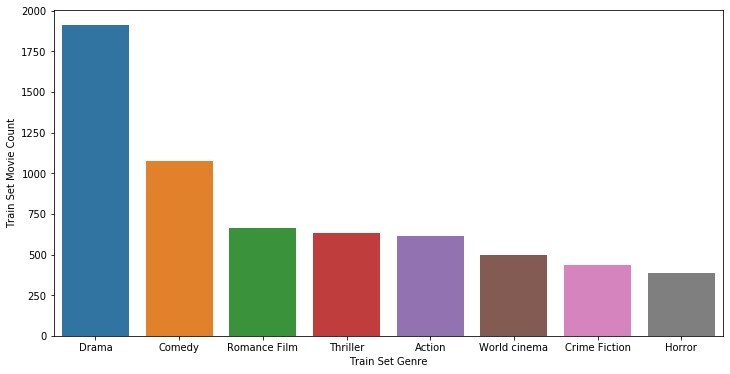

In [44]:
render_genre_freq(Y_train_genre_freq)

In [45]:
def hot_onecode_utility(df):
    df = df.sum(axis=1)
    hot_onecode = to_categorical(df, num_classes=MAX_COUNT, dtype=int)
    #print("hot_onecode ->", type(hot_onecode), hot_onecode.shape, "nulls=", df.isnull().sum())
    assert df.shape[0]==len(df), "out shape mismatch"
    return hot_onecode


In [46]:
model.compile(optimizer='adam',
              loss=({'pred_label': 'binary_crossentropy', 'pred_count': 'binary_crossentropy'}),
              loss_weights=({'pred_label': 1., 'pred_count': 1.}),
              metrics=({'pred_label': 'accuracy', 'pred_count': 'accuracy'}))

In [47]:
callbacks = [ReduceLROnPlateau(),
             EarlyStopping(patience=4),
             ModelCheckpoint(filepath=model_file, save_best_only=True)]

In [48]:
def train_model(X_train3, Y_train):
    Y_train_count = hot_onecode_utility(Y_train)
    history = model.fit(X_train3,
                        {'pred_label': Y_train, 'pred_count': Y_train_count},
                        batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2,
                       callbacks = callbacks)
    return history

In [49]:
def get_triple_input(df):
    
    X_train3 = [ df.iloc[:,i*SEQUENCE_LEN:(i+1)*SEQUENCE_LEN] for i in range(3)]

    X_train3 = [np.asarray(X_train3[0], dtype=np.int32),
           np.asarray(X_train3[1], dtype=np.int32), 
           np.asarray(X_train3[2], dtype=np.int32)]

    return X_train3

In [50]:
X_train3 = get_triple_input(X_train)

In [51]:
def assert_train3_XY():
    print("triple_input ->", type(triple_input),"\nX_train3 ->", type(X_train3))
    print("triple_input ->", len(triple_input), "\nX_train3 ->", len(X_train3))
    print("triple_input[0] ->", type(triple_input[0]), "\nX_train3[0] ->", type(X_train3[0]))
    print("triple_input[0] ->", len(triple_input[0]), "\nX_train3[0] ->", len(X_train3[0]))
    print("triple_input[0] ->", triple_input[0].shape, "\nX_train3[0] ->", X_train3[0].shape)
    print("triple_input[1] ->", triple_input[1].shape, "\nX_train3[1] ->", X_train3[1].shape)
    print("triple_input[2] ->", triple_input[2].shape, "\nX_train3[2] ->", X_train3[2].shape)

    assert (len(X_train3)==3 and
            type(X_train3[0]) is np.ndarray and
            type(X_train3[1]) is np.ndarray and
            type(X_train3[2]) is np.ndarray and
            X_train3[0].shape[0]== Y_train.shape[0] and
            X_train3[1].shape[0]== Y_train.shape[0] and
            X_train3[2].shape[0]== Y_train.shape[0] and
            X_train3[0].shape[1]== SEQUENCE_LEN and
            X_train3[1].shape[1]== SEQUENCE_LEN and
            X_train3[2].shape[1]== SEQUENCE_LEN), " X_train3 and or Y_train inouts are inconsistent"
    return
assert_train3_XY()

triple_input -> <class 'list'> 
X_train3 -> <class 'list'>
triple_input -> 3 
X_train3 -> 3
triple_input[0] -> <class 'numpy.ndarray'> 
X_train3[0] -> <class 'numpy.ndarray'>
triple_input[0] -> 42071 
X_train3[0] -> 3456
triple_input[0] -> (42071, 200) 
X_train3[0] -> (3456, 200)
triple_input[1] -> (42071, 200) 
X_train3[1] -> (3456, 200)
triple_input[2] -> (42071, 200) 
X_train3[2] -> (3456, 200)


In [52]:
history = train_model(X_train3, Y_train)

Train on 2764 samples, validate on 692 samples
Epoch 1/4
2764/2764 [==============================] - 830s 300ms/sample - loss: 0.7584 - pred_label_loss: 0.5037 - pred_count_loss: 0.2548 - pred_label_accuracy: 0.7733 - pred_count_accuracy: 0.8757 - val_loss: 0.7207 - val_pred_label_loss: 0.4728 - val_pred_count_loss: 0.2486 - val_pred_label_accuracy: 0.7946 - val_pred_count_accuracy: 0.8752
Epoch 2/4
2764/2764 [==============================] - 834s 302ms/sample - loss: 0.7199 - pred_label_loss: 0.4709 - pred_count_loss: 0.2488 - pred_label_accuracy: 0.7944 - pred_count_accuracy: 0.8755 - val_loss: 0.7059 - val_pred_label_loss: 0.4614 - val_pred_count_loss: 0.2449 - val_pred_label_accuracy: 0.8015 - val_pred_count_accuracy: 0.8799
Epoch 3/4
2764/2764 [==============================] - 864s 313ms/sample - loss: 0.7093 - pred_label_loss: 0.4602 - pred_count_loss: 0.2492 - pred_label_accuracy: 0.8012 - pred_count_accuracy: 0.8791 - val_loss: 0.6961 - val_pred_label_loss: 0.4531 - val_pred

In [53]:
[print(key) for key in history.history.keys()]

loss
pred_label_loss
pred_count_loss
pred_label_accuracy
pred_count_accuracy
val_loss
val_pred_label_loss
val_pred_count_loss
val_pred_label_accuracy
val_pred_count_accuracy
lr


[None, None, None, None, None, None, None, None, None, None, None]

In [54]:
def render_model_metrics(title, train_meas, val_meas):
    
    plt.plot(history.history[train_meas])
    plt.plot(history.history[val_meas])

    ylabel = str(train_meas).upper()
    
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('EPOCH')
    plt.legend([train_meas, val_meas], loc='lower right')
    plt.show()

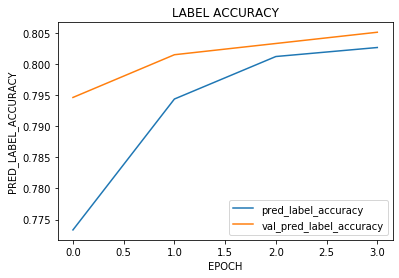

In [55]:
render_model_metrics('LABEL ACCURACY', 'pred_label_accuracy', 'val_pred_label_accuracy')

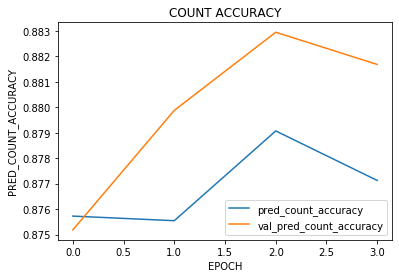

In [56]:
render_model_metrics('COUNT ACCURACY', 'pred_count_accuracy', 'val_pred_count_accuracy')

## Predictions Y_preds for X_test

In [57]:
TEST_SLICE = 12
def create_test_random(X_pool, Y_pool):
    assert isinstance(X_pool, pd.DataFrame), "X input should be a pandas dataframe"
    assert isinstance(Y_pool, pd.DataFrame), "Y input should be a pandas dataframe"
    XY_pool = Y_pool.join(X_pool)
    XY_test = XY_pool.sample(TEST_SLICE)
    X_test  = XY_test.iloc[:,Y_pool.shape[1]:]
    Y_test  = XY_test.iloc[:,:Y_pool.shape[1]]
    print("X_test:", X_test.shape)
    print("Y_test:", Y_test.shape)

    return(X_test , Y_test )
    

In [58]:
X_test , Y_test  = create_test_random(X_pool, Y_pool)

X_test: (12, 600)
Y_test: (12, 8)


In [59]:
def make_prediction(X_test):
    Y_preds = model.predict(X_test)
    print("Y_preds[0]:{} {}\nY_preds_count:{} {}".format(
        type(Y_preds[0]), Y_preds[0].shape, type(Y_preds[1]), Y_preds[1].shape))
    return Y_preds

In [60]:
X_test3 = get_triple_input(X_test)

In [61]:
Y_preds = make_prediction(X_test3)

Y_preds[0]:<class 'numpy.ndarray'> (12, 8)
Y_preds_count:<class 'numpy.ndarray'> (12, 8)


## Results

In [62]:
def get_true_labels(test):
    true =[i for i in test.to_numpy()]
    true = np.array(true)
    
    true_labels = []
    for i, row in enumerate(true):
        arr = []
        for j, val in enumerate(row):
            if val==1:
                arr.append(genres[j])
        true_labels.append(arr)
    return true_labels

In [63]:
def get_pred_counts(counts):
    per_row_sum = [round((sum(row, 0))) for row in counts]
    #print("counts_prediction per_row_sum:", per_row_sum, "row_count: ", len(counts))
    assert (sum(per_row_sum)/len(counts)==1), "label_counts prabablity dists do not add to 100%"
    
    pred_counts = np.argmax(counts, axis=1)
    #print("labels counts model output -> argmax:{}\n{}".format(pred_counts, counts))
    return pred_counts

In [64]:
def get_pred_labels(labels):    
    labels_sorted_idx = np.argsort(-labels)
    labels_sorted = -np.sort(-labels)
    
    pred_counts = get_pred_counts(Y_preds[1])
            
    pred_labels = []
    for i, row_vals in enumerate(labels_sorted):
        #print("model output labels_sorted sample#{}\n{}".format( i, labels_sorted[i]))
        #print("labels_sorted idx\n{}".format(labels_sorted_idx[i]))
        #print("----------------------------")
        arr = []
        for j, row_val in enumerate(row_vals):
            label_idx = labels_sorted_idx[i,j]
            arr.append(genres[label_idx])
            if j+1== pred_counts[i]: break
        pred_labels.append(arr)

    return pred_labels

In [65]:
def print_final_results(test, preds):

    pred_labels = get_pred_labels(preds[0])
    pred_counts = [len(row) for row in pred_labels]
    
    true_labels = get_true_labels(test)   
    true_counts = [len(row) for row in true_labels]

    df_results = pd.DataFrame(columns=["true_labels", "pred_labels", "true_counts", "pred_counts", "labels","labels_count"])
    df_results["true_labels"] = true_labels
    df_results["pred_labels"] = pred_labels
    df_results["true_counts"] = true_counts
    df_results["pred_counts"] = pred_counts
        
    labels_str = [str(row) for row in preds[0]]
    df_results["labels"] = labels_str
    
    labels_count_str = [str(row) for row in preds[1]]
    df_results["labels_count"] = labels_count_str

    return df_results



In [66]:
df_results = print_final_results(Y_test, Y_preds)

In [67]:
df_results

,true_labels,pred_labels,true_counts,pred_counts,labels,labels_count
0,[Crime Fiction],[Drama],1,1,[0.22 0.32 0.11 0.53 0.18 0.26 0.19 0.17],[2.20e-04 3.60e-01 3.42e-01 2.08e-01 5.71e-02 ...
1,"[Drama, Romance Film]",[Drama],2,1,[0.16 0.48 0.1 0.53 0.11 0.23 0.09 0.14],[8.42e-05 4.58e-01 2.74e-01 2.11e-01 4.13e-02 ...
2,"[Action, Comedy]",[Action],2,1,[0.33 0.23 0.12 0.27 0.18 0.11 0.15 0.17],[1.95e-05 7.01e-01 1.59e-01 9.59e-02 4.19e-02 ...
3,[Drama],[Drama],1,1,[0.2 0.17 0.07 0.52 0.18 0.24 0.12 0.26],[5.85e-05 4.54e-01 2.84e-01 1.95e-01 5.28e-02 ...
4,"[Drama, Romance Film, World cinema]",[Drama],3,1,[0.17 0.28 0.07 0.46 0.14 0.22 0.09 0.33],[4.42e-05 5.57e-01 2.13e-01 1.67e-01 5.15e-02 ...
5,[Drama],[Drama],1,1,[0.14 0.32 0.08 0.48 0.13 0.16 0.13 0.12],[2.63e-05 5.25e-01 2.89e-01 1.47e-01 3.49e-02 ...
6,[Drama],[Comedy],1,1,[0.23 0.42 0.12 0.36 0.18 0.15 0.16 0.17],[1.46e-04 4.53e-01 2.58e-01 1.97e-01 6.95e-02 ...
7,"[Action, Comedy, Thriller]",[Drama],3,1,[0.23 0.38 0.15 0.52 0.13 0.15 0.2 0.1 ],[1.05e-04 3.71e-01 3.51e-01 2.26e-01 3.93e-02 ...
8,"[Drama, World cinema]",[Drama],2,1,[0.22 0.23 0.1 0.46 0.14 0.19 0.09 0.33],[3.81e-05 5.99e-01 2.30e-01 1.03e-01 5.81e-02 ...
9,[Drama],[Drama],1,1,[0.25 0.22 0.11 0.39 0.19 0.2 0.17 0.1 ],[3.28e-05 5.30e-01 2.29e-01 1.86e-01 5.04e-02 ...
